# Match Winner Prediction

In this notebook, we will:
- Clean the dataset (drop unnecessary columns, nulls, duplicates).
- Perform Exploratory Data Analysis (EDA).
- Encode features.
- Check feature correlations.
- Build classification model to predict predict the outcome of football matches (**Home Win, Draw, or Away Win**) using match statistics.
- Evaluate models using metrics like accuracy, confusion matrix, and classification report.

## Step 1: Load Dataset
We’ll begin by importing the required libraries and loading the dataset.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [3]:
# Load dataset
df = pd.read_csv("Match Winner.csv")
df.head()

,Season,MatchDate,HomeTeam,AwayTeam,FullTimeHomeGoals,FullTimeAwayGoals,FullTimeResult,HalfTimeHomeGoals,HalfTimeAwayGoals,HalfTimeResult,...,HomeShotsOnTarget,AwayShotsOnTarget,HomeCorners,AwayCorners,HomeFouls,AwayFouls,HomeYellowCards,AwayYellowCards,HomeRedCards,AwayRedCards
0,2000/01,2000-08-19,Charlton,Man City,4,0,H,2,0,H,...,14,4,6,6,13,12,1,2,0,0
1,2000/01,2000-08-19,Chelsea,West Ham,4,2,H,1,0,H,...,10,5,7,7,19,14,1,2,0,0
2,2000/01,2000-08-19,Coventry,Middlesbrough,1,3,A,1,1,D,...,3,9,8,4,15,21,5,3,1,0
3,2000/01,2000-08-19,Derby,Southampton,2,2,D,1,2,A,...,4,6,5,8,11,13,1,1,0,0
4,2000/01,2000-08-19,Leeds,Everton,2,0,H,2,0,H,...,8,6,6,4,21,20,1,3,0,0


## Step 2: Drop Unnecessary Columns

We drop columns that do not contribute to predicting the match result or could cause **data leakage**:  

- `Season`, `MatchDate` → not predictive  
- `FullTimeHomeGoals`, `FullTimeAwayGoals` → reveal final result  
- `HomeRedCards`, `AwayRedCards`, `HomeYellowCards`, `AwayYellowCards` → post-match stats

In [4]:
df = df.drop([
    "Season", 
    "MatchDate", 
    "FullTimeHomeGoals", 
    "FullTimeAwayGoals", 
    "HomeYellowCards", 
    "AwayYellowCards", 
    "HomeRedCards", 
    "AwayRedCards"
], axis=1)
df.head()

,HomeTeam,AwayTeam,FullTimeResult,HalfTimeHomeGoals,HalfTimeAwayGoals,HalfTimeResult,HomeShots,AwayShots,HomeShotsOnTarget,AwayShotsOnTarget,HomeCorners,AwayCorners,HomeFouls,AwayFouls
0,Charlton,Man City,H,2,0,H,17,8,14,4,6,6,13,12
1,Chelsea,West Ham,H,1,0,H,17,12,10,5,7,7,19,14
2,Coventry,Middlesbrough,A,1,1,D,6,16,3,9,8,4,15,21
3,Derby,Southampton,D,1,2,A,6,13,4,6,5,8,11,13
4,Leeds,Everton,H,2,0,H,17,12,8,6,6,4,21,20


## Step 3: Check for Null Values
We check for missing values in each column.  
If there are any, we will drop those rows.

In [5]:
print("Missing values before handling:")
print(df.isnull().sum())

if df.isnull().sum().sum() == 0:
    print("\nNo missing values found")
else:
    df = df.dropna()
    print("\nMissing values handled. After dropping:")
    print(df.isnull().sum())

Missing values before handling:
HomeTeam             0
AwayTeam             0
FullTimeResult       0
HalfTimeHomeGoals    0
HalfTimeAwayGoals    0
HalfTimeResult       0
HomeShots            0
AwayShots            0
HomeShotsOnTarget    0
AwayShotsOnTarget    0
HomeCorners          0
AwayCorners          0
HomeFouls            0
AwayFouls            0
dtype: int64

No missing values found


## Step 4: Check for Duplicate Rows

Duplicates can bias our model, so we check and remove them if present.

In [6]:
print("Duplicates before:", df.duplicated().sum())
df = df.drop_duplicates()
print("Duplicates after:", df.duplicated().sum())

Duplicates before: 0
Duplicates after: 0


## Step 5: Encode Categorical Variables

- `HomeTeam` and `AwayTeam` → One-hot encoding  
- `HalfTimeResult` → Label encoding  
- `FullTimeResult` → Label encoding (target)


In [7]:
# Encode target
le_target = LabelEncoder()
y = le_target.fit_transform(df["FullTimeResult"])  # H=0, D=1, A=2

# Encode HalfTimeResult
le_ht = LabelEncoder()
df["HalfTimeResult"] = le_ht.fit_transform(df["HalfTimeResult"])  # H=0, D=1, A=2

# One-hot encode team names
X = df.drop("FullTimeResult", axis=1)
X = pd.get_dummies(X, columns=["HomeTeam", "AwayTeam"])

# Preview
X.head()

,HalfTimeHomeGoals,HalfTimeAwayGoals,HalfTimeResult,HomeShots,AwayShots,HomeShotsOnTarget,AwayShotsOnTarget,HomeCorners,AwayCorners,HomeFouls,...,AwayTeam_Southampton,AwayTeam_Stoke,AwayTeam_Sunderland,AwayTeam_Swansea,AwayTeam_Tottenham,AwayTeam_Watford,AwayTeam_West Brom,AwayTeam_West Ham,AwayTeam_Wigan,AwayTeam_Wolves
0,2,0,2,17,8,14,4,6,6,13,...,False,False,False,False,False,False,False,False,False,False
1,1,0,2,17,12,10,5,7,7,19,...,False,False,False,False,False,False,False,True,False,False
2,1,1,1,6,16,3,9,8,4,15,...,False,False,False,False,False,False,False,False,False,False
3,1,2,0,6,13,4,6,5,8,11,...,True,False,False,False,False,False,False,False,False,False
4,2,0,2,17,12,8,6,6,4,21,...,False,False,False,False,False,False,False,False,False,False


## Step 6: Train/Test Split

We split the data into training and testing sets (80%-20%).  
Stratify by target to maintain class proportions.

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## Step 7: Train Models with Class Imbalance Handling

We train:  
- **Logistic Regression** with balanced class weights  
- **Random Forest Classifier** with balanced class weights

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Logistic Regression with class weights
lr = LogisticRegression(max_iter=1000, class_weight="balanced")
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Random Forest with class weights
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

## Step 8: Model Evaluation

We evaluate both models using:  

- Accuracy  
- Classification Report (precision, recall, F1-score)  
- Confusion Matrix (visual)

--- Logistic Regression (Balanced) ---
Accuracy: 0.6178038379530917

Classification Report:
               precision    recall  f1-score   support

           A       0.65      0.68      0.66       554
           D       0.37      0.45      0.40       462
           H       0.79      0.67      0.72       860

    accuracy                           0.62      1876
   macro avg       0.60      0.60      0.60      1876
weighted avg       0.64      0.62      0.63      1876



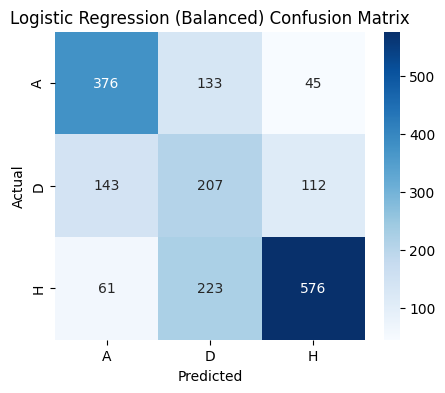



--- Random Forest (Balanced) ---
Accuracy: 0.6321961620469083

Classification Report:
               precision    recall  f1-score   support

           A       0.63      0.71      0.67       554
           D       0.39      0.24      0.30       462
           H       0.70      0.79      0.75       860

    accuracy                           0.63      1876
   macro avg       0.58      0.58      0.57      1876
weighted avg       0.61      0.63      0.61      1876



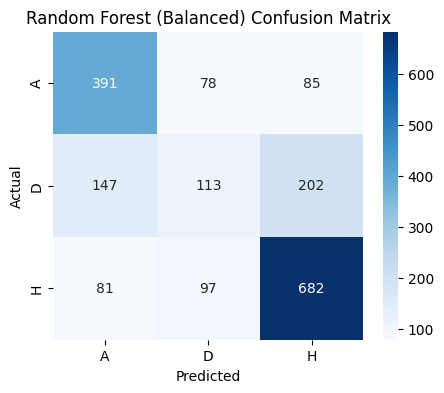

In [10]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(y_true, y_pred, model_name):
    print(f"--- {model_name} ---")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=le_target.classes_))
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le_target.classes_, yticklabels=le_target.classes_)
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    print("\n")

evaluate_model(y_test, y_pred_lr, "Logistic Regression (Balanced)")
evaluate_model(y_test, y_pred_rf, "Random Forest (Balanced)")

## Step 9: Sample Predictions

We compare actual vs predicted match results for a few test cases.

In [11]:
comparison = pd.DataFrame({
    "Actual": le_target.inverse_transform(y_test[:10]),
    "Predicted_LR": le_target.inverse_transform(y_pred_lr[:10]),
    "Predicted_RF": le_target.inverse_transform(y_pred_rf[:10])
})
comparison

,Actual,Predicted_LR,Predicted_RF
0,D,D,H
1,A,D,D
2,H,A,H
3,H,H,H
4,H,D,D
5,H,H,H
6,D,D,A
7,A,D,A
8,H,D,H
9,H,H,H


## Step 10: Hyperparameter Tuning

To improve performance, we apply hyperparameter tuning using GridSearchCV.  
We will tune both Logistic Regression and Random Forest, then compare results.

In [14]:
# Logistic Regression Hyperparameters
param_grid_lr = {
    "C": [0.01, 0.1, 1, 10],
    "solver": ["lbfgs", "saga"],  # better for multiclass
    "penalty": ["l2"]
}

grid_lr = GridSearchCV(
    LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42),
    param_grid_lr,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)
grid_lr.fit(X_train, y_train)

best_lr = grid_lr.best_estimator_
y_pred_lr_tuned = best_lr.predict(X_test)

print("Best Logistic Regression Params:", grid_lr.best_params_)

Best Logistic Regression Params: {'C': 0.01, 'penalty': 'l2', 'solver': 'saga'}


## Step 11: Random Forest Hyperparameter Tuning
We tune important parameters such as:
- `n_estimators` (number of trees)
- `max_depth` (tree depth)
- `min_samples_split` (minimum samples to split)

In [15]:
# Random Forest Hyperparameters
param_grid_rf = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

grid_rf = GridSearchCV(
    RandomForestClassifier(class_weight="balanced", random_state=42),
    param_grid_rf,
    cv=3,
    scoring="accuracy",
    n_jobs=-1
)
grid_rf.fit(X_train, y_train)

best_rf = grid_rf.best_estimator_
y_pred_rf_tuned = best_rf.predict(X_test)

print("Best Random Forest Params:", grid_rf.best_params_)

Best Random Forest Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


## Step 12: Evaluate Tuned Models
We compare the tuned models with classification report, accuracy, and confusion matrix.

In [16]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Logistic Regression Evaluation
print("--- Tuned Logistic Regression ---")
print("Accuracy:", accuracy_score(y_test, y_pred_lr_tuned))
print(classification_report(y_test, y_pred_lr_tuned, target_names=le_target.classes_))

# Random Forest Evaluation
print("\n--- Tuned Random Forest ---")
print("Accuracy:", accuracy_score(y_test, y_pred_rf_tuned))
print(classification_report(y_test, y_pred_rf_tuned, target_names=le_target.classes_))

--- Tuned Logistic Regression ---
Accuracy: 0.6231343283582089
              precision    recall  f1-score   support

           A       0.66      0.68      0.67       554
           D       0.38      0.47      0.42       462
           H       0.79      0.67      0.72       860

    accuracy                           0.62      1876
   macro avg       0.61      0.61      0.60      1876
weighted avg       0.65      0.62      0.63      1876


--- Tuned Random Forest ---
Accuracy: 0.6380597014925373
              precision    recall  f1-score   support

           A       0.63      0.70      0.66       554
           D       0.42      0.26      0.32       462
           H       0.71      0.80      0.75       860

    accuracy                           0.64      1876
   macro avg       0.59      0.59      0.58      1876
weighted avg       0.61      0.64      0.62      1876



## Step 13: Visualizing Confusion Matrices
We plot confusion matrices for both tuned models.

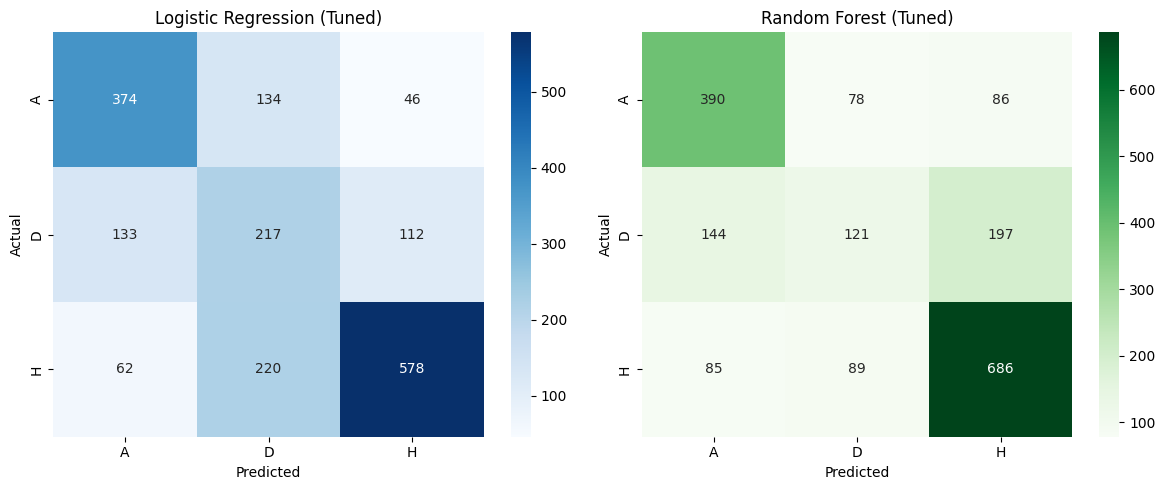

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Logistic Regression Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_lr_tuned), annot=True, fmt="d",
            cmap="Blues", xticklabels=le_target.classes_, yticklabels=le_target.classes_, ax=axes[0])
axes[0].set_title("Logistic Regression (Tuned)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# Random Forest Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_rf_tuned), annot=True, fmt="d",
            cmap="Greens", xticklabels=le_target.classes_, yticklabels=le_target.classes_, ax=axes[1])
axes[1].set_title("Random Forest (Tuned)")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

## Step 14: Sample Predictions (Tuned Models)
Let's again compare actual vs predicted results after hyperparameter tuning.

In [18]:
comparison_tuned = pd.DataFrame({
    "Actual": le_target.inverse_transform(y_test[:10]),
    "Predicted_LR_Tuned": le_target.inverse_transform(y_pred_lr_tuned[:10]),
    "Predicted_RF_Tuned": le_target.inverse_transform(y_pred_rf_tuned[:10])
})
comparison_tuned

,Actual,Predicted_LR_Tuned,Predicted_RF_Tuned
0,D,D,H
1,A,D,D
2,H,A,H
3,H,H,H
4,H,D,D
5,H,H,H
6,D,D,A
7,A,D,D
8,H,D,H
9,H,H,H


## Step 15: Conclusion
- Logistic Regression vs Random Forest performance compared.  
- Hyperparameter tuning slightly improved the results.  
- Logistic Regression performed better on class `D` (Draws) compared to Random Forest.  
- Random Forest captured `H` (Home Wins) and `A` (Away Wins) slightly better.  

Overall, both models hover around ~62–64% accuracy.